In [1]:
from typing import TypedDict,Annotated,Sequence
from langchain_core.messages import BaseMessage,ToolMessage,SystemMessage,HumanMessage,AIMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from pathlib import Path
import os
import json

In [2]:
dotenv_path = Path('.env')
load_dotenv(dotenv_path=dotenv_path)
api_key=os.getenv("deepseekkey")
# api_key=os.getenv("gptAPIKEY")
# print(api_key)

In [70]:
class Agent(TypedDict):
    message : Annotated[Sequence[BaseMessage], add_messages]
    parsed : json

In [68]:
filecontents=""
with open("events.txt",'a+') as file:
    file.seek(0)
    filecontents=(file.read())
filecontents

''

In [ ]:
# model= ChatOpenAI(model="z-ai/glm-4.5-air:free",api_key=api_key,base_url="https://openrouter.ai/api/v1").bind_tools(tools)

model= ChatOpenAI(model="deepseek/deepseek-chat-v3-0324:free",api_key=api_key,base_url="https://openrouter.ai/api/v1")

In [92]:
def process(state: Agent) -> Agent:
    system_prompt = SystemMessage(content=f"""
    You are a scheduling assistant. 
    Output ONLY in JSON format:
    {{
        "event": "...",
        "date-time": "D/M-H:M",
        "priority": "high|medium|low"
    }}
    the contents of this conversation are {filecontents}    
    """)
    
    user_input = HumanMessage(content=input("Enter your task: "))
    final_messages = [system_prompt, user_input]
    
    response = model.invoke(final_messages)  # no `input=...`
    
    print("Full Response:", )
    if isinstance(response, AIMessage):
        print("AI says:", response.content)
        return {"message": [response]}
    else:
        print("Unexpected response type:", type(response))
        return {"message": []}

    
def printmessage(state:Agent)->Agent:
    val=state['message']
    val=val[1].content
    val=val.replace(' ','')
    val=val.replace('\n','')
    val=val.replace('n\'s',"n ")
    val=val.replace("json","")
    state['parsed']=json.loads(val)
    print("k",state['parsed'])
    return state

def savecontent(state:Agent)->Agent:
    val=state['parsed']
    print("t",val)
    val={'event': 'meeting', 'date-time': '12/12/2023-00:00', 'priority': 'medium'}
    with open("events.txt",'a+') as file:
        file.write(f"{val}\n")
    state['message']=[]
    state['parsed']={}
    return state

In [93]:
graph=StateGraph(Agent)
graph.add_node("user",process)
graph.add_node("printmessage",printmessage)
graph.add_node("save",savecontent)
graph.set_entry_point("user")
graph.add_edge("user","printmessage")
graph.add_edge("printmessage",'save')
graph.add_edge('save',END)
app=graph.compile()

In [94]:
# son's birthday tomorrow  
res=app.invoke({'message':'','parsed':''})
print('f',res)

Full Response:
AI says: json
{
    "event": "meeting",
    "date-time": "12/12",
    "priority": "medium"
}

k {'event': 'meeting', 'date-time': '12/12', 'priority': 'medium'}
t {'event': 'meeting', 'date-time': '12/12', 'priority': 'medium'}
f {'message': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='924adb29-081d-4999-9665-981263b4c9a6'), AIMessage(content='json\n{\n    "event": "meeting",\n    "date-time": "12/12",\n    "priority": "medium"\n}\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 311, 'total_tokens': 343, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'deepseek/deepseek-chat-v3-0324:free', 'system_fingerprint': None, 'id': 'gen-1754890849-OgrPBICnY24fye5JXB2m', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--7add7c01-64bd-4e6c-a28d-f940dba25d85-0', usage_metadata={'input_tokens': 311, 'output_tokens': 32, 'total_tok

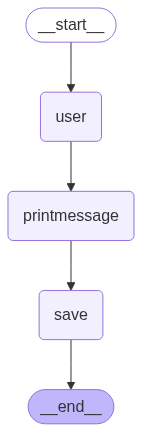

In [89]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))